In [10]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix, roc_curve

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'
plt.rcParams.update({
    'text.usetex':False,
    'font.family':'monospace'
})  
import seaborn as sns

import optuna
from xgboost import XGBClassifier

## Loading the dataset, pre-processing, and analysing the data

In [3]:
cohort_data = pd.read_csv('../cohort_data_new.csv')
cohort_data

,icustay_id,anion_gap_mean,anion_gap_sd,anion_gap_min,anion_gap_max,bicarbonate_mean,bicarbonate_sd,bicarbonate_min,bicarbonate_max,calcium_total_mean,...,urea_nitrogen_min,urea_nitrogen_max,white_blood_cells_mean,white_blood_cells_sd,white_blood_cells_min,white_blood_cells_max,age,gender,icu_los_hours,target
0,200003,13.375000,3.583195,9.0,21.0,25.250000,3.105295,18.0,28.0,7.771429,...,10.0,21.0,26.471429,13.176711,13.2,43.9,48,M,141,0
1,200007,15.500000,2.121320,14.0,17.0,23.000000,1.414214,22.0,24.0,8.900000,...,8.0,10.0,10.300000,1.272792,9.4,11.2,44,M,30,0
2,200009,9.500000,2.121320,8.0,11.0,23.333333,2.081666,21.0,25.0,8.000000,...,15.0,21.0,12.471429,1.471637,10.5,14.3,47,F,51,0
3,200012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.900000,NaN,4.9,4.9,33,F,10,0
4,200014,10.000000,1.732051,9.0,12.0,24.000000,1.000000,23.0,25.0,7.733333,...,21.0,24.0,13.233333,2.203028,10.7,14.7,85,M,41,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30484,299992,15.375000,2.856153,11.0,25.0,23.125000,2.609556,15.0,26.0,8.307143,...,8.0,23.0,14.134783,3.781727,8.1,22.1,41,M,499,0
30485,299993,9.400000,1.341641,8.0,11.0,29.600000,2.073644,26.0,31.0,8.000000,...,12.0,15.0,12.600000,0.605530,12.0,13.3,26,M,67,0
30486,299994,16.157895,2.477973,13.0,24.0,21.631579,3.451417,17.0,31.0,8.100000,...,28.0,63.0,10.076190,2.642329,5.3,14.5,74,F,152,1
30487,299998,11.500000,1.732051,10.0,14.0,23.500000,1.290994,22.0,25.0,8.800000,...,20.0,22.0,9.900000,1.210372,7.9,11.0,87,M,46,1


In [4]:
# REmove the ICUstay_id and the gender
drop_cols = [c for c in cohort_data.columns if 'icustay_id' in c.lower() or 'gender' in c.lower()]
df = cohort_data.drop(columns=['icustay_id', 'gender'], errors='ignore')

X = df.drop(columns=['target'])
y = df['target']

# Keep only numeric
X = X.select_dtypes(include=['number']).replace([np.inf, -np.inf], np.nan)

print(f"Final feature matrix shape: {X.shape}")

Final feature matrix shape: (30489, 94)


In [6]:
# Test-Train split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
print(f"Train Full: {X_train_full.shape}, Test: {X_test.shape}")

Train Full: (21342, 94), Test: (9147, 94)


In [7]:
def objective(trial):
    # Train-Dev split for 
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42)

    # Handle imbalance
    scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])

    params = {
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
        "max_depth": trial.suggest_int("max_depth", 3, 25),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 15),
        "gamma": trial.suggest_float("gamma", 0.0, 1.0),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 2.0),
        "n_estimators": trial.suggest_int("n_estimators", 300, 5000),
        "max_delta_step": trial.suggest_int("max_delta_step", 0, 10),
        "scale_pos_weight": scale_pos_weight,
        "random_state": 42,
        "eval_metric": "auc",
        "tree_method": "hist",
        "use_label_encoder": False
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    y_val_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred)

    return auc

Hyperparameters

In [8]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25, show_progress_bar=True)

print("Search for hyperparameters complete:")
print(study.best_params)

[I 2025-11-27 16:13:36,939] A new study created in memory with name: no-name-b86afc1d-b65f-4293-9f66-d7371a54acff


  0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\risha\AppData\Local\Temp\ipykernel_5364\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:37] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-27 16:14:13,109] Trial 0 finished with value: 0.7075577971054272 and parameters: {'learning_rate': 0.021773599948994995, 'max_depth': 20, 'min_child_weight': 6, 'gamma': 0.2700257448281267, 'subsample': 0.5834053359321077, 'colsample_bytree': 0.6663303970431225, 'reg_alpha': 0.316546192981746, 'reg_lambda': 0.6927967583369067, 'n_estimators': 2547, 'max_delta_step': 0}. Best is trial 0 with value: 0.7075577971054272.


C:\Users\risha\AppData\Local\Temp\ipykernel_5364\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:13] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-27 16:15:09,225] Trial 1 finished with value: 0.7151456149680636 and parameters: {'learning_rate': 0.0053245518178062, 'max_depth': 15, 'min_child_weight': 13, 'gamma': 0.2506456659688924, 'subsample': 0.47315934913303626, 'colsample_bytree': 0.8948311895845713, 'reg_alpha': 0.01424413011909486, 'reg_lambda': 1.4523006896295345, 'n_estimators': 3053, 'max_delta_step': 8}. Best is trial 1 with value: 0.7151456149680636.


C:\Users\risha\AppData\Local\Temp\ipykernel_5364\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:15:09] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-27 16:15:43,962] Trial 2 finished with value: 0.7082256874753401 and parameters: {'learning_rate': 0.0027760882658776753, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 0.699822191000493, 'subsample': 0.7502211565169478, 'colsample_bytree': 0.45161962276778544, 'reg_alpha': 0.6901259868114316, 'reg_lambda': 1.6219681316920798, 'n_estimators': 1837, 'max_delta_step': 1}. Best is trial 1 with value: 0.7151456149680636.


C:\Users\risha\AppData\Local\Temp\ipykernel_5364\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:15:44] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-27 16:15:59,051] Trial 3 finished with value: 0.7044173399893641 and parameters: {'learning_rate': 0.007641363133620607, 'max_depth': 15, 'min_child_weight': 5, 'gamma': 0.4010069001356735, 'subsample': 0.640285394363111, 'colsample_bytree': 0.8058508428691632, 'reg_alpha': 0.23025733281890784, 'reg_lambda': 0.8516472337464823, 'n_estimators': 351, 'max_delta_step': 2}. Best is trial 1 with value: 0.7151456149680636.


C:\Users\risha\AppData\Local\Temp\ipykernel_5364\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:15:59] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-27 16:16:24,202] Trial 4 finished with value: 0.6946305731391418 and parameters: {'learning_rate': 0.009754268781284652, 'max_depth': 3, 'min_child_weight': 7, 'gamma': 0.06493431639500347, 'subsample': 0.9589633169230689, 'colsample_bytree': 0.7136048810080609, 'reg_alpha': 0.6417627198706933, 'reg_lambda': 0.7148518688361073, 'n_estimators': 4673, 'max_delta_step': 0}. Best is trial 1 with value: 0.7151456149680636.


C:\Users\risha\AppData\Local\Temp\ipykernel_5364\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:16:24] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-27 16:16:43,006] Trial 5 finished with value: 0.681005723957708 and parameters: {'learning_rate': 0.13565672696315517, 'max_depth': 16, 'min_child_weight': 10, 'gamma': 0.3977546905043804, 'subsample': 0.49572158119858045, 'colsample_bytree': 0.4630471974175519, 'reg_alpha': 0.4882870377314635, 'reg_lambda': 0.7970852834805439, 'n_estimators': 2917, 'max_delta_step': 2}. Best is trial 1 with value: 0.7151456149680636.


C:\Users\risha\AppData\Local\Temp\ipykernel_5364\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:16:43] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-27 16:17:09,592] Trial 6 finished with value: 0.6954236929534136 and parameters: {'learning_rate': 0.0756481323836911, 'max_depth': 8, 'min_child_weight': 2, 'gamma': 0.6230906335049705, 'subsample': 0.8374349298586155, 'colsample_bytree': 0.7333585423959107, 'reg_alpha': 0.6413400517969836, 'reg_lambda': 0.39013155387403975, 'n_estimators': 4615, 'max_delta_step': 5}. Best is trial 1 with value: 0.7151456149680636.


C:\Users\risha\AppData\Local\Temp\ipykernel_5364\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:17:09] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-27 16:17:32,246] Trial 7 finished with value: 0.707671590070849 and parameters: {'learning_rate': 0.0026531803703228195, 'max_depth': 4, 'min_child_weight': 7, 'gamma': 0.9150538582838612, 'subsample': 0.7070128783494667, 'colsample_bytree': 0.9360912649153751, 'reg_alpha': 0.2636696383383844, 'reg_lambda': 1.9573190384223902, 'n_estimators': 3034, 'max_delta_step': 8}. Best is trial 1 with value: 0.7151456149680636.


C:\Users\risha\AppData\Local\Temp\ipykernel_5364\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:17:32] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-27 16:18:13,770] Trial 8 finished with value: 0.7111031055758553 and parameters: {'learning_rate': 0.006954591487711151, 'max_depth': 22, 'min_child_weight': 8, 'gamma': 0.6043462656067458, 'subsample': 0.9125441283818408, 'colsample_bytree': 0.7377509468876657, 'reg_alpha': 0.860827494426539, 'reg_lambda': 1.4185387961782725, 'n_estimators': 1081, 'max_delta_step': 9}. Best is trial 1 with value: 0.7151456149680636.


C:\Users\risha\AppData\Local\Temp\ipykernel_5364\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:18:13] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-27 16:19:35,171] Trial 9 finished with value: 0.7141763733781642 and parameters: {'learning_rate': 0.0047325470837964526, 'max_depth': 14, 'min_child_weight': 6, 'gamma': 0.09809017660085317, 'subsample': 0.4888571721033884, 'colsample_bytree': 0.9694483848097174, 'reg_alpha': 0.30802006744052, 'reg_lambda': 0.9297033835102029, 'n_estimators': 3214, 'max_delta_step': 8}. Best is trial 1 with value: 0.7151456149680636.


C:\Users\risha\AppData\Local\Temp\ipykernel_5364\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:19:35] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-27 16:20:13,218] Trial 10 finished with value: 0.6849981987545674 and parameters: {'learning_rate': 0.03833821973873992, 'max_depth': 25, 'min_child_weight': 15, 'gamma': 0.2016755107439726, 'subsample': 0.4081746365410983, 'colsample_bytree': 0.8785128086203279, 'reg_alpha': 0.028645283614143265, 'reg_lambda': 0.06683582797046783, 'n_estimators': 3882, 'max_delta_step': 6}. Best is trial 1 with value: 0.7151456149680636.


C:\Users\risha\AppData\Local\Temp\ipykernel_5364\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:20:13] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-27 16:21:29,475] Trial 11 finished with value: 0.7140703000360249 and parameters: {'learning_rate': 0.0012968366170096545, 'max_depth': 12, 'min_child_weight': 12, 'gamma': 0.03981876577244179, 'subsample': 0.4161580354424892, 'colsample_bytree': 0.9915435363729441, 'reg_alpha': 0.020829359403952752, 'reg_lambda': 1.2649947966629438, 'n_estimators': 3706, 'max_delta_step': 10}. Best is trial 1 with value: 0.7151456149680636.


C:\Users\risha\AppData\Local\Temp\ipykernel_5364\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:21:29] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-27 16:22:20,082] Trial 12 finished with value: 0.714357927481287 and parameters: {'learning_rate': 0.0035828445251336106, 'max_depth': 18, 'min_child_weight': 14, 'gamma': 0.20496287362128782, 'subsample': 0.5425008745249927, 'colsample_bytree': 0.9025381083768126, 'reg_alpha': 0.1765453981267155, 'reg_lambda': 1.2042868332187169, 'n_estimators': 2172, 'max_delta_step': 7}. Best is trial 1 with value: 0.7151456149680636.


C:\Users\risha\AppData\Local\Temp\ipykernel_5364\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:22:20] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-27 16:23:08,807] Trial 13 finished with value: 0.7080678640660114 and parameters: {'learning_rate': 0.0010729583227621175, 'max_depth': 19, 'min_child_weight': 15, 'gamma': 0.2831448571264299, 'subsample': 0.5148374646037828, 'colsample_bytree': 0.8490629593723917, 'reg_alpha': 0.10951863836159915, 'reg_lambda': 1.264290777336518, 'n_estimators': 1936, 'max_delta_step': 6}. Best is trial 1 with value: 0.7151456149680636.


C:\Users\risha\AppData\Local\Temp\ipykernel_5364\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:23:08] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-27 16:23:42,259] Trial 14 finished with value: 0.7108269146095301 and parameters: {'learning_rate': 0.017157085993144586, 'max_depth': 16, 'min_child_weight': 12, 'gamma': 0.4160144869694076, 'subsample': 0.594231692512786, 'colsample_bytree': 0.6463233716688979, 'reg_alpha': 0.12583318897279583, 'reg_lambda': 1.691559391545592, 'n_estimators': 2103, 'max_delta_step': 4}. Best is trial 1 with value: 0.7151456149680636.


C:\Users\risha\AppData\Local\Temp\ipykernel_5364\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:23:42] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-27 16:23:53,036] Trial 15 finished with value: 0.673217481801703 and parameters: {'learning_rate': 0.29833114190956517, 'max_depth': 19, 'min_child_weight': 13, 'gamma': 0.19979171238802484, 'subsample': 0.5596271332347786, 'colsample_bytree': 0.5702368494586946, 'reg_alpha': 0.42495805358048555, 'reg_lambda': 1.1458610742213764, 'n_estimators': 1316, 'max_delta_step': 7}. Best is trial 1 with value: 0.7151456149680636.


C:\Users\risha\AppData\Local\Temp\ipykernel_5364\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:23:53] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-27 16:25:38,290] Trial 16 finished with value: 0.7171335609192643 and parameters: {'learning_rate': 0.00261521322504761, 'max_depth': 23, 'min_child_weight': 11, 'gamma': 0.5106806457415286, 'subsample': 0.6634097844767249, 'colsample_bytree': 0.8953827875193981, 'reg_alpha': 0.1421101877728704, 'reg_lambda': 1.6166110205996893, 'n_estimators': 3935, 'max_delta_step': 10}. Best is trial 16 with value: 0.7171335609192643.


C:\Users\risha\AppData\Local\Temp\ipykernel_5364\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:25:38] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-27 16:27:44,403] Trial 17 finished with value: 0.7152225252889141 and parameters: {'learning_rate': 0.002089068060239956, 'max_depth': 25, 'min_child_weight': 10, 'gamma': 0.8273901416887082, 'subsample': 0.7741200819177381, 'colsample_bytree': 0.8199771416806974, 'reg_alpha': 0.011819461832500279, 'reg_lambda': 1.9696484832353294, 'n_estimators': 4029, 'max_delta_step': 10}. Best is trial 16 with value: 0.7171335609192643.


C:\Users\risha\AppData\Local\Temp\ipykernel_5364\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:27:44] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-27 16:30:50,523] Trial 18 finished with value: 0.7156233738756512 and parameters: {'learning_rate': 0.0018219410963035035, 'max_depth': 25, 'min_child_weight': 9, 'gamma': 0.9963613546086607, 'subsample': 0.7656045970215244, 'colsample_bytree': 0.7991309070219188, 'reg_alpha': 0.9848860792154985, 'reg_lambda': 1.9763138224934547, 'n_estimators': 3934, 'max_delta_step': 10}. Best is trial 16 with value: 0.7171335609192643.


C:\Users\risha\AppData\Local\Temp\ipykernel_5364\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:30:50] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-27 16:35:00,265] Trial 19 finished with value: 0.7169442871928591 and parameters: {'learning_rate': 0.0016681873087575842, 'max_depth': 22, 'min_child_weight': 10, 'gamma': 0.9837328748884273, 'subsample': 0.8257529420677003, 'colsample_bytree': 0.7799636054448522, 'reg_alpha': 0.977585309351076, 'reg_lambda': 1.7458569826956074, 'n_estimators': 4957, 'max_delta_step': 10}. Best is trial 16 with value: 0.7171335609192643.


C:\Users\risha\AppData\Local\Temp\ipykernel_5364\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:35:00] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-27 16:36:06,463] Trial 20 finished with value: 0.7136745978648092 and parameters: {'learning_rate': 0.013919387863005098, 'max_depth': 22, 'min_child_weight': 11, 'gamma': 0.7803329514746338, 'subsample': 0.8459618684681901, 'colsample_bytree': 0.6082004437867418, 'reg_alpha': 0.8334212263231905, 'reg_lambda': 1.6338705429153602, 'n_estimators': 4988, 'max_delta_step': 9}. Best is trial 16 with value: 0.7171335609192643.


C:\Users\risha\AppData\Local\Temp\ipykernel_5364\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:36:06] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-27 16:39:31,485] Trial 21 finished with value: 0.7146589927893 and parameters: {'learning_rate': 0.0014732413839949395, 'max_depth': 23, 'min_child_weight': 9, 'gamma': 0.999674954890817, 'subsample': 0.8079163745414285, 'colsample_bytree': 0.7786097508758236, 'reg_alpha': 0.9989466675629314, 'reg_lambda': 1.7820849758944064, 'n_estimators': 4134, 'max_delta_step': 10}. Best is trial 16 with value: 0.7171335609192643.


C:\Users\risha\AppData\Local\Temp\ipykernel_5364\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:39:31] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-27 16:42:25,535] Trial 22 finished with value: 0.7167898947272113 and parameters: {'learning_rate': 0.0019612899553084345, 'max_depth': 23, 'min_child_weight': 9, 'gamma': 0.9464741773160114, 'subsample': 0.678213030273497, 'colsample_bytree': 0.7742110517287868, 'reg_alpha': 0.9507504821390546, 'reg_lambda': 1.8344288504489752, 'n_estimators': 3546, 'max_delta_step': 9}. Best is trial 16 with value: 0.7171335609192643.


C:\Users\risha\AppData\Local\Temp\ipykernel_5364\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:42:25] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-27 16:44:59,937] Trial 23 finished with value: 0.7144282618267487 and parameters: {'learning_rate': 0.0035839261427003427, 'max_depth': 21, 'min_child_weight': 11, 'gamma': 0.8536066516926218, 'subsample': 0.6730695264397031, 'colsample_bytree': 0.7577503595566593, 'reg_alpha': 0.8468084396668137, 'reg_lambda': 1.7863829003600005, 'n_estimators': 3482, 'max_delta_step': 9}. Best is trial 16 with value: 0.7171335609192643.


C:\Users\risha\AppData\Local\Temp\ipykernel_5364\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:45:00] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-27 16:50:29,885] Trial 24 finished with value: 0.7173594313782672 and parameters: {'learning_rate': 0.0020444845495506576, 'max_depth': 23, 'min_child_weight': 3, 'gamma': 0.7328434958216264, 'subsample': 0.6432938899815452, 'colsample_bytree': 0.8528986518087387, 'reg_alpha': 0.9010904629578748, 'reg_lambda': 1.4421403869933942, 'n_estimators': 4475, 'max_delta_step': 9}. Best is trial 24 with value: 0.7173594313782672.
Search for hyperparameters complete:
{'learning_rate': 0.0020444845495506576, 'max_depth': 23, 'min_child_weight': 3, 'gamma': 0.7328434958216264, 'subsample': 0.6432938899815452, 'colsample_bytree': 0.8528986518087387, 'reg_alpha': 0.9010904629578748, 'reg_lambda': 1.4421403869933942, 'n_estimators': 4475, 'max_delta_step': 9}


In [9]:
# using the best hyperparams for final training on complete training set
best_params = study.best_params
best_params.update({
    "random_state": 42,
    "eval_metric": "auc",
    "tree_method": "hist",
    "use_label_encoder": False,
    "scale_pos_weight": (y_train_full.value_counts()[0] / y_train_full.value_counts()[1])
})

final_model = XGBClassifier(**best_params)
final_model.fit(X_train_full, y_train_full)

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:50:30] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8528986518087387, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, feature_weights=None,
              gamma=0.7328434958216264, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0020444845495506576,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=9, max_depth=23, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=4475, n_jobs=None,
              num_parallel_tree=None, ...)

Evaluate

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94      8164
           1       0.48      0.09      0.15       983

    accuracy                           0.89      9147
   macro avg       0.69      0.54      0.55      9147
weighted avg       0.85      0.89      0.86      9147

ROC-AUC: 0.7401


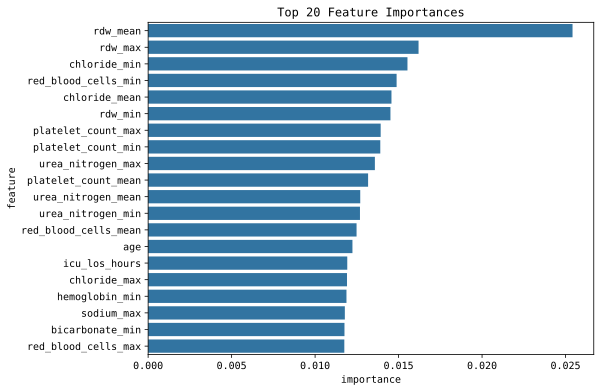

In [11]:
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
auprc = average_precision_score(y_test, y_proba)

print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc:.4f}")

import matplotlib.pyplot as plt
import seaborn as sns

importances = final_model.feature_importances_
feat_imp = pd.DataFrame({'feature': X.columns, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(y='feature', x='importance', data=feat_imp)
plt.title("Top 20 Feature Importances")
plt.show()